In [80]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

In [81]:
ds_xlsx = pd.read_excel("..\Assets\dry_bean_dataset\Raisin_Dataset\Raisin_Dataset.xlsx")
df =  pd.DataFrame(ds_xlsx)

In [82]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
column = 'Class'
df[column] = label_encoder.fit_transform(df[column])

In [83]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5)
df_imputed = imputer.fit_transform(df)
df_imputed = pd.DataFrame(df_imputed, columns=df.columns)

In [84]:
missing_values = df.isnull().sum().sum()
print(missing_values)

0


In [85]:
from sklearn.feature_selection import mutual_info_classif

X = df.drop('Class', axis=1)
y = df['Class']
mi_scores = mutual_info_classif(X, y)

mi_df = pd.DataFrame({'Feature': X.columns, 'MI_Score': mi_scores})

sorted_features = [feature for _, feature in sorted(zip(mi_scores, X.columns), reverse=True)]
# sorted_features = mi_df.sort_values(by='MI_Score', ascending=False)['Feature'].tolist()
best_error_rate = float('inf')
std_best = float('inf')
i_best = -1
selected_features = sorted_features.copy()
error_rate_history = []
std_dev_history = []
print(sorted_features)

['Perimeter', 'MajorAxisLength', 'ConvexArea', 'Area', 'MinorAxisLength', 'Eccentricity', 'Extent']


In [86]:
clf = DecisionTreeClassifier(random_state=42)
error_rates_all = 1 - cross_val_score(clf, df[selected_features], y, cv=10, scoring='accuracy')
mean_error_rate_all = np.mean(error_rates_all)
std_dev_all = np.std(error_rates_all)
error_rate_history.append(mean_error_rate_all)
std_dev_history.append(std_dev_all)
print("Features selected: ", selected_features)
print("Mean Error Rate:", mean_error_rate_all)
print("Standard deviation", std_dev_all)

Features selected:  ['Perimeter', 'MajorAxisLength', 'ConvexArea', 'Area', 'MinorAxisLength', 'Eccentricity', 'Extent']
Mean Error Rate: 0.19
Standard deviation 0.03564225540521208


In [87]:
for i in range(1, len(sorted_features)):
    X_selected = df[selected_features[:-i]]
    error_rates = 1 - cross_val_score(clf, X_selected, y, cv=10, scoring='accuracy')
    
    mean_error_rate = np.mean(error_rates)
    std_dev = np.std(error_rates)

    error_rate_history.append(mean_error_rate)
    std_dev_history.append(std_dev)

    print("Features selected: ", selected_features[:-i])
    print("Mean Error Rate:", mean_error_rate)
    print("Standard deviation:", std_dev)
    print("Best Error Rate:", best_error_rate)
    # If the error rate is lower, update the best features and error rate
    if mean_error_rate < best_error_rate:
        best_error_rate = mean_error_rate
        std_best = std_dev
        i_best = i
    else:
        continue

Features selected:  ['Perimeter', 'MajorAxisLength', 'ConvexArea', 'Area', 'MinorAxisLength', 'Eccentricity']
Mean Error Rate: 0.19
Standard deviation: 0.038313199221259246
Best Error Rate: inf
Features selected:  ['Perimeter', 'MajorAxisLength', 'ConvexArea', 'Area', 'MinorAxisLength']
Mean Error Rate: 0.2011111111111111
Standard deviation: 0.026504134315281248
Best Error Rate: 0.19
Features selected:  ['Perimeter', 'MajorAxisLength', 'ConvexArea', 'Area']
Mean Error Rate: 0.2
Standard deviation: 0.03103164454170877
Best Error Rate: 0.19
Features selected:  ['Perimeter', 'MajorAxisLength', 'ConvexArea']
Mean Error Rate: 0.17888888888888893
Standard deviation: 0.03494263376336974
Best Error Rate: 0.19
Features selected:  ['Perimeter', 'MajorAxisLength']
Mean Error Rate: 0.20555555555555555
Standard deviation: 0.04223683957499603
Best Error Rate: 0.17888888888888893
Features selected:  ['Perimeter']
Mean Error Rate: 0.19333333333333333
Standard deviation: 0.028196838978776704
Best Error

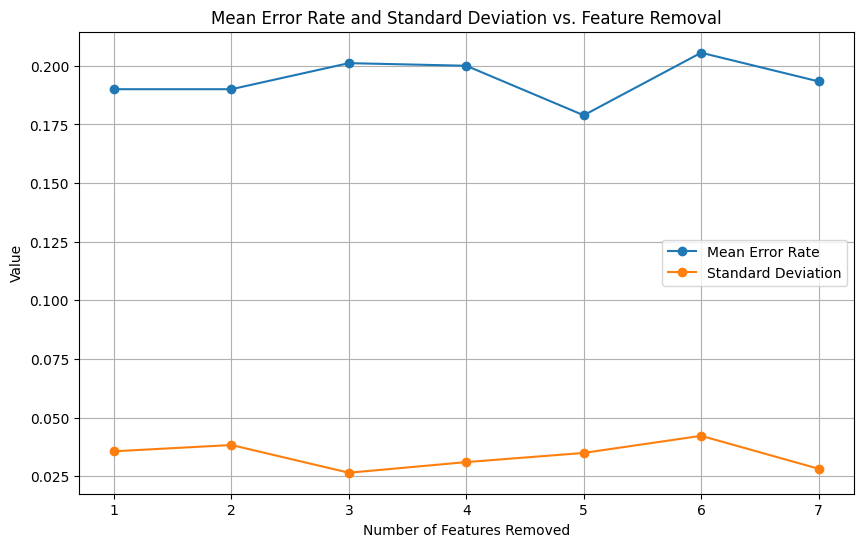

Selected Features: ['Perimeter', 'MajorAxisLength', 'ConvexArea']
Best Error Rate: 0.17888888888888893
Standard deviation: 0.03494263376336974


In [88]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(error_rate_history) + 1), error_rate_history, label='Mean Error Rate', marker='o')
plt.plot(range(1, len(std_dev_history) + 1), std_dev_history, label='Standard Deviation', marker='o')
plt.xlabel('Number of Features Removed')
plt.ylabel('Value')
plt.legend()
plt.title('Mean Error Rate and Standard Deviation vs. Feature Removal')
plt.grid()
plt.show()


print("Selected Features:", selected_features[:-i_best])
print("Best Error Rate:", best_error_rate)
print("Standard deviation:", std_best)

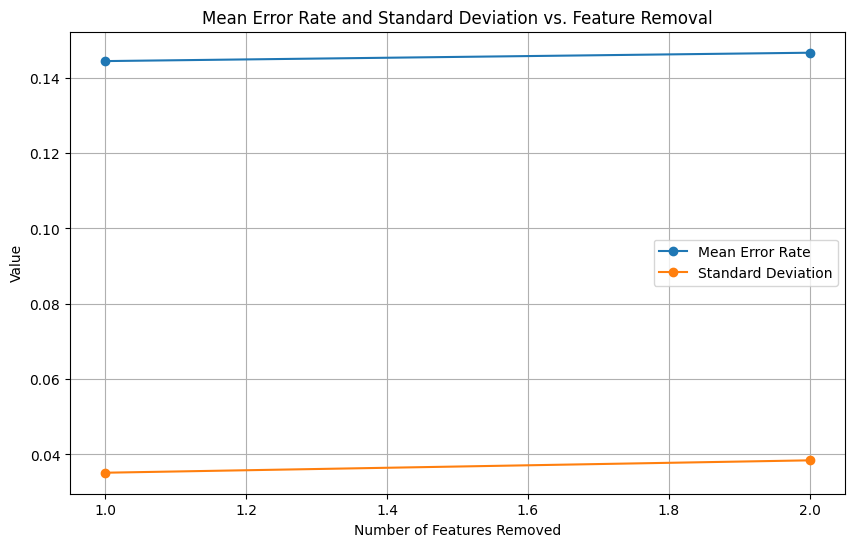

Selected Features: ['Perimeter', 'MajorAxisLength', 'ConvexArea', 'Area', 'MinorAxisLength']
Best Error Rate: 0.14444444444444446
Best Tree Depth: 1


In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV


# Separate the target variable ('class_label') from the features
X = df.drop(columns=['Class'])
y = df['Class']

# Calculate Mutual Information (MI) for each feature with the class label
mi_scores = mutual_info_classif(X, y, random_state=42)

# Create a DataFrame to store MI scores with feature names
mi_df = pd.DataFrame({'Feature': X.columns, 'MI_Score': mi_scores})

# Sort features by MI in descending order
sorted_features = mi_df.sort_values(by='MI_Score', ascending=False)['Feature'].tolist()

# Initialize variables
best_error_rate = float('inf')
selected_features = sorted_features.copy()
error_rate_history = []
std_dev_history = []

# Create a decision tree classifier
clf = DecisionTreeClassifier(random_state=42)  # You can tune other hyperparameters here

# Define a range of tree depths to search through
tree_depths = list(range(1, 11))  # Example: Search depths from 1 to 10

# Perform iterative feature selection
for i in range(1, len(sorted_features)):
    # Build a classifier with the selected features
    X_selected = df[selected_features[:-i]]

    # Define hyperparameters to search
    param_grid = {
        'max_depth': tree_depths
    }

    # Grid search with cross-validation to find the best tree depth
    grid_search = GridSearchCV(clf, param_grid, cv=10, scoring='accuracy')
    grid_search.fit(X_selected, y)

    # Get the best tree depth
    best_tree_depth = grid_search.best_params_['max_depth']

    # Set the best tree depth for the classifier
    clf.set_params(max_depth=best_tree_depth)

    # Calculate error rates using 10-fold cross-validation
    error_rates = 1 - cross_val_score(clf, X_selected, y, cv=10, scoring='accuracy')
    mean_error_rate = np.mean(error_rates)
    std_dev = np.std(error_rates)

    # Store error rate and standard deviation
    error_rate_history.append(mean_error_rate)
    std_dev_history.append(std_dev)

    # If the error rate is lower, update the best features and error rate
    if mean_error_rate < best_error_rate:
        best_error_rate = mean_error_rate
    else:
        continue

# Plot mean error rates and standard deviations
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(error_rate_history) + 1), error_rate_history, label='Mean Error Rate', marker='o')
plt.plot(range(1, len(std_dev_history) + 1), std_dev_history, label='Standard Deviation', marker='o')
plt.xlabel('Number of Features Removed')
plt.ylabel('Value')
plt.legend()
plt.title('Mean Error Rate and Standard Deviation vs. Feature Removal')
plt.grid()
plt.show()

# Print the selected features, best error rate, best tree depth, and error rate history
print("Selected Features:", selected_features[:-i])  # Features selected based on MI
print("Best Error Rate:", best_error_rate)
print("Best Tree Depth:", best_tree_depth)
